Found classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images (valid): 4752
label
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
dtype: int64


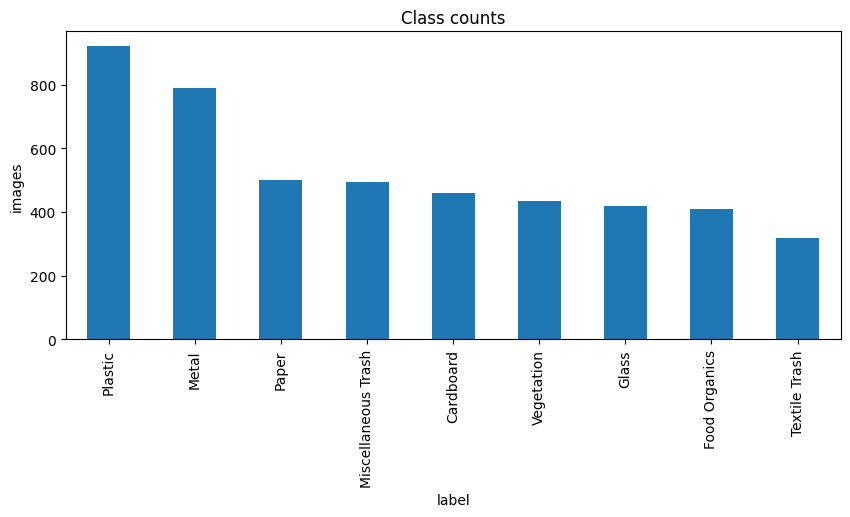

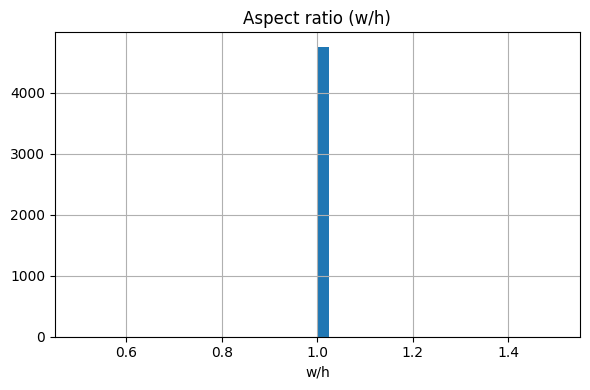

Saved manifest_clean.csv and classes.json


In [ ]:
# --- Notebook: 01_EDA_and_Cleanup.ipynb ---

import os, json, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# 0) Config
DATASET_DIR = r"C:\Users\User\Desktop\CNN asignment\realwaste\realwaste-main\RealWaste"
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}
RANDOM_SEED = 42
MIN_SIZE = 32
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 1) Scan folders -> dataframe of files
rows = []
root = Path(DATASET_DIR)
classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
print("Found classes:", classes)

for cls in classes:
    for p in (root/cls).rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            try:
                with Image.open(p) as im:
                    im.verify()  # quick integrity check
                with Image.open(p) as im:
                    w,h = im.size
            except Exception as e:
                print("Corrupt:", p, e)
                continue
            rows.append({"path": str(p), "label": cls, "w": w, "h": h})

df = pd.DataFrame(rows)
print("Total images (valid):", len(df))
print(df.groupby("label").size().sort_values(ascending=False))

# 2) Basic visuals
plt.figure(figsize=(10,4))
ax = df["label"].value_counts().plot(kind="bar", title="Class counts")
ax.set_ylabel("images")
plt.show()

plt.figure(figsize=(6,4))
(df["w"]/df["h"]).clip(0,5).hist(bins=40)
plt.title("Aspect ratio (w/h)")
plt.xlabel("w/h"); plt.tight_layout(); plt.show()

# 3) Filter tiny images
df = df[(df["w"] >= MIN_SIZE) & (df["h"] >= MIN_SIZE)].reset_index(drop=True)
print("After filtering tiny images:", len(df))

# 4) Filter extreme aspect ratios
df["aspect_ratio"] = df["w"] / df["h"]
df = df[(df["aspect_ratio"] > 0.2) & (df["aspect_ratio"] < 5)].reset_index(drop=True)
print("After filtering extreme aspect ratios:", len(df))

# 5) Drop exact path duplicates
df = df.drop_duplicates(subset=["path"]).reset_index(drop=True)

# 6) Optional: near-duplicate removal via average hash
# import imagehash
# def ah(p): return str(imagehash.average_hash(Image.open(p).convert("RGB")))
# df["ahash"] = df["path"].apply(ah)
# before = len(df)
# df = df.drop_duplicates(subset=["label","ahash"]).reset_index(drop=True)
# print(f"Removed near-duplicates: {before - len(df)}")

# 7) Optional: remove blurry images (requires cv2)
# import cv2
# def is_blurry(p, threshold=100):
#     img = cv2.imread(p)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     return cv2.Laplacian(gray, cv2.CV_64F).var() < threshold
# df["blurry"] = df["path"].apply(is_blurry)
# df = df[~df["blurry"]].reset_index(drop=True)
# print("Removed blurry images")

# 8) Convert grayscale -> RGB for safety
def ensure_rgb(p):
    im = Image.open(p)
    if im.mode != "RGB":
        im = im.convert("RGB")
    return im

# 9) Compute dataset mean/std for transforms
sample_imgs = df.sample(min(500,len(df)), random_state=RANDOM_SEED)["path"].tolist()
img_stack = []
for p in sample_imgs:
    im = ensure_rgb(p).resize((256,256))
    img_stack.append(np.array(im).astype(np.float32)/255.0)
img_stack = np.stack(img_stack)
mean = img_stack.mean(axis=(0,1,2))
std = img_stack.std(axis=(0,1,2))
print("Dataset mean:", mean)
print("Dataset std:", std)

# 10) Visualize few images per class
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 3*len(classes)))
for i, cls in enumerate(classes):
    cls_paths = df[df["label"]==cls]["path"].tolist()
    sample_paths = random.sample(cls_paths, min(5, len(cls_paths)))
    for j, p in enumerate(sample_paths):
        im = ensure_rgb(p)
        axes[i,j].imshow(im)
        axes[i,j].axis('off')
        if j==0: axes[i,j].set_ylabel(cls)
plt.tight_layout()
plt.show()

# 11) Save cleaned manifest
df.to_csv("manifest_clean.csv", index=False)
with open("classes.json","w") as f:
    json.dump(classes, f)
print("Saved manifest_clean.csv and classes.json")

# 12) Train/Val/Test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=RANDOM_SEED)

train_df.to_csv("train_manifest.csv", index=False)
val_df.to_csv("val_manifest.csv", index=False)
test_df.to_csv("test_manifest.csv", index=False)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
